# 案例：基于随机森林分类器的偏差方差调参
## 目录

高手调参多依赖于经验，这些经验来源于:
1. 非常正确的调参思路和方法
2. 对模型评估指标的理解
3. 对数据的感觉和经验
4. 用洪荒之力不断地尝试

一个集成模型(f)在未知数据集(D)上的泛化误差E(f;D),由方差(var),偏差(bias)和噪声($\epsilon$)共同决定
$$E(f;D) = bias^2(x) + var(x) + \epsilon^2$$

|-|偏差大|偏差小|
|:--|:--|:--|
|方差大|模型不适合这个数据<br>换模型|过拟合<br>模型很复杂<br>对某些数据集预测很准确<br>对某些数据集预测很糟糕|
|方差小|欠拟合<br>模型相对简单<br>预测很稳定<br>但对所有的数据预测都不太准确|泛化误差小，我们的目标|

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
data = load_breast_cancer()
data.data.shape

(569, 30)

乳腺癌数据集有569条记录，30个特征，但看维度虽然不算太高，但是样本量非常少。过拟合的情况可能存在

## 进行一次简单的建模，看看模型本身在数据集上的效果

In [7]:
rfc = RandomForestClassifier(n_estimators=100,random_state=90)
score_pre = cross_val_score(rfc,data.data,data.target,cv=10).mean()
score_pre

0.9666925935528475

## 随机森林调整的第一步，无论如何先来调n_estimators

在这里选择学习曲线的原因在于，使用学习曲线，可以看到趋势。  
看到n_estimators在什么取值开始变得平稳，是否一直推动模型整体准确率的上升。  
第一次的学习曲线，可以帮我们划定范围，我们取每十个数为一个阶段，来观察n_estimators的变化如何影响模型整体准确率的变化

0.9685388039063175 101


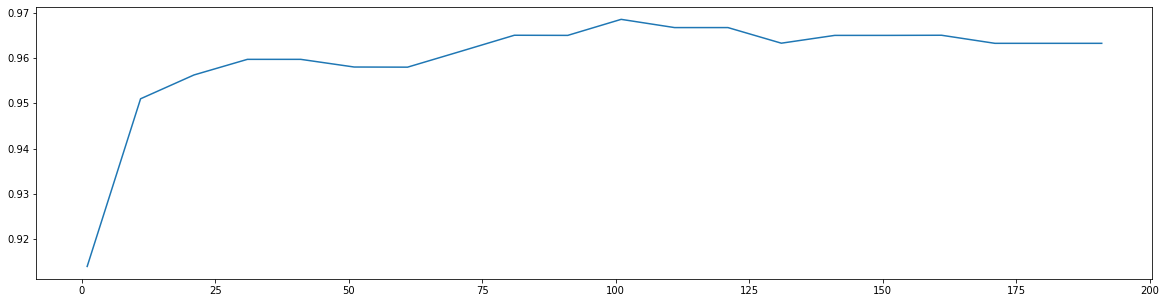

In [10]:
scorelist = []
for i in range(1,200,10):
    rfc = RandomForestClassifier(n_estimators=i,
                                n_jobs=-1,
                                random_state=666 
                                )
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorelist.append(score)
    
print(max(scorelist),[*range(1,200,10)][scorelist.index(max(scorelist))])
plt.figure(figsize=(20,5))
plt.plot(range(1,200,10),scorelist)
plt.show()

在确定好的范围内，进一步细化学习曲线

0.9702629418373518 99


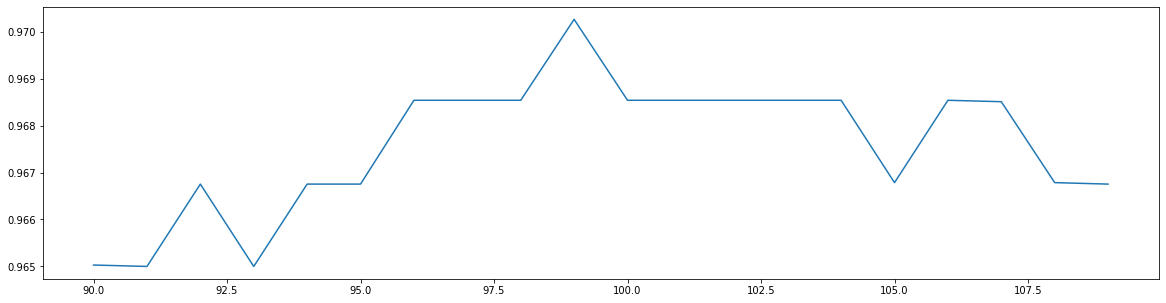

In [11]:
scorelist = []
for i in range(90,110):
    rfc = RandomForestClassifier(n_estimators=i,
                                n_jobs=-1,
                                random_state=666 
                                )
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorelist.append(score)
    
print(max(scorelist),[*range(90,110)][scorelist.index(max(scorelist))])
plt.figure(figsize=(20,5))
plt.plot(range(90,110),scorelist)
plt.show()

调整max_depth

In [15]:
param_grid = {"max_depth":np.arange(1,20,1)}

rfc = RandomForestClassifier(n_estimators=99,random_state=666,n_jobs=-1)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=99, n_jobs=-1,
                                              oob_score=False, random_state=666,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_

In [16]:
GS.best_params_

{'max_depth': 8}

In [17]:
GS.best_score_

0.9701230228471002

调整max_features

In [18]:
param_grid = {"max_features":np.arange(5,30)}

rfc = RandomForestClassifier(n_estimators=99,random_state=666)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=99, n_jobs=None,
                                              oob_score=False, random_state=666,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'ma

In [19]:
GS.best_params_

{'max_features': 5}

In [20]:
GS.best_score_

0.9701230228471002

复杂度和泛化误差的关系已经告诉我们，模型不能再进步了。调参和训练模型都需要更长的时间，明知道模型不能进步还继续调整，不是一个有效率的做法。  
如果我们希望模型更进一步，可以选择更换算法，或者更换做数据预处理的方式。

总结：
在调参过程中，首先调整了n_estimators(无论如何请先走这一步)  
调整max_depth，通过max_depth产生的结果，判断模型位于复杂度～泛化误差的哪一边。从而选择我们的调整方向。